In [1]:
import os

In [2]:
os.getcwd()

'/home/marc/Git/HARK_dev'

In [4]:
#change the line below to your local HARK file location
os.chdir('/home/marc/Git/HARK')

In [5]:
os.getcwd()

'/home/marc/Git/HARK'

In [6]:
ls

cAndCwithStickyE/   FashionVictim/        HARKparallel.py    LICENSE
ConsumptionSaving/  HARKcore.py           HARKsimulation.py  README.md
cstwMPC/            HARKestimation.py     HARKutilities.py   SolvingMicroDSOPs/
Documentation/      HARKinterpolation.py  __index__.py       Testing/


# Implementation of a Tractable Model Of Buffer Stock Saving 


This notebook implements the Carroll et. al.'s Tractable Model of Buffer Stock Saving (2009) using HARK.  The notebook is intended as a guide to using HARK, and provides only a basic outline of the model.  For a full theoretical explanation, see the [Lecture Notes for the Tractable Model](http://www.econ2.jhu.edu/people/ccarroll/public/LectureNotes/Consumption/TractableBufferStock.pdf).  

To begin, we import several routines from HARK.  They will be explained as they used throughout the notebook, but by convention, imports are written at the begining of all code.

In [9]:
    import numpy as np                   # numeric Python
    from time import clock               # timing utility
    
    import scipy 
    from scipy import *
    from HARKutilities import plotFuncs  # basic plotting tools
    from HARKcore import AgentType
    os.chdir(os.getcwd()+"/ConsumptionSaving")
    #SHOULD BE MOVED    from ConsMarkovModel import MarkovConsumerType # An alternative, much longer way to solve the TBS model    
    from TractableBufferStockModel import addToStableArmPoints, TractableConsumerSolution
    

In [10]:
class TractableConsumerType(AgentType):

    def __init__(self,cycles=0,time_flow=False,**kwds):
        '''
        Instantiate a new TractableConsumerType with given data.
        
        Parameters
        ----------
        cycles : int
            Number of times the sequence of periods should be solved.
        time_flow : boolean
            Whether time is currently "flowing" forward for this instance.
        
        Returns:
        -----------
        New instance of TractableConsumerType.
        '''            
        # Initialize a basic AgentType
        AgentType.__init__(self,cycles=cycles,time_flow=time_flow,pseudo_terminal=True,**kwds)

        # Add consumer-type specific objects, copying to create independent versions
        self.time_vary = []
        self.time_inv = ['DiscFac','Rfree','CRRA','PermGroFacCmp','UnempPrb','PFMPC','Rnrm','Beth','mLowerBnd','mUpperBnd']
        self.shock_vars = ['eStateNow']
        self.poststate_vars = ['aLvlNow','eStateNow'] # For simulation
        self.solveOnePeriod = addToStableArmPoints # set correct solver
        
    def preSolve(self):
        '''
        Calculates all of the solution objects that can be obtained before con-
        ducting the backshooting routine, including the target levels, the per-
        fect foresight solution, (marginal) consumption at m=0, and the small
        perturbations around the steady state.
        
        Parameters
        ----------
        none
        
        Returns
        -------
        none
        '''
        # Define utility functions
        uPP = lambda x : utilityPP(x,gam=self.CRRA)
        uPPP = lambda x : utilityPPP(x,gam=self.CRRA)
        uPPPP = lambda x : utilityPPPP(x,gam=self.CRRA)
        
        # Define some useful constants from model primitives
        self.PermGroFacCmp = self.PermGroFac/(1.0-self.UnempPrb) #"uncertainty compensated" wage growth factor
        self.Rnrm = self.Rfree/self.PermGroFacCmp # net interest factor (Rfree normalized by wage growth)
        self.PFMPC= 1.0-(self.Rfree**(-1.0))*(self.Rfree*self.DiscFac)**(1.0/self.CRRA) # MPC for a perfect forsight consumer
        self.Beth = self.Rnrm*self.DiscFac*self.PermGroFacCmp**(1.0-self.CRRA)
        
        # Verify that this consumer is impatient
        PatFacGrowth = (self.Rfree*self.DiscFac)**(1.0/self.CRRA)/self.PermGroFacCmp 
        PatFacReturn = (self.Rfree*self.DiscFac)**(1.0/self.CRRA)/self.Rfree
        if PatFacReturn >= 1.0:
            raise Exception("Employed consumer not return impatient, cannot solve!")
        if PatFacGrowth >= 1.0:
            raise Exception("Employed consumer not growth impatient, cannot solve!")
            
        # Find target money and consumption
        Pi = (1+(PatFacGrowth**(-self.CRRA)-1.0)/self.UnempPrb)**(1/self.CRRA)
        self.h = (1.0/(1.0-self.PermGroFac/self.Rfree))
        zeta = self.Rnrm*self.PFMPC*Pi
        self.mTarg = 1.0+(self.Rfree/(self.PermGroFacCmp+zeta*self.PermGroFacCmp-self.Rfree))
        self.cTarg = (1.0-self.Rnrm**(-1.0))*self.mTarg+self.Rnrm**(-1.0)
        mTargU = (self.mTarg - self.cTarg)*self.Rnrm
        cTargU = mTargU*self.PFMPC
        self.SSperturbance = self.mTarg*0.1
        
        # Find the MPC, MMPC, and MMMPC at the target
        mpcTargFixedPointFunc = lambda k : k*uPP(self.cTarg) - self.Beth*((1.0-self.UnempPrb)*(1.0-k)*k*self.Rnrm*uPP(self.cTarg)+self.PFMPC*self.UnempPrb*(1.0-k)*self.Rnrm*uPP(cTargU))
        self.MPCtarg = newton(mpcTargFixedPointFunc,0)
        mmpcTargFixedPointFunc = lambda kk : kk*uPP(self.cTarg) + self.MPCtarg**2.0*uPPP(self.cTarg) - self.Beth*(-(1.0 - self.UnempPrb)*self.MPCtarg*kk*self.Rnrm*uPP(self.cTarg)+(1.0-self.UnempPrb)*(1.0 - self.MPCtarg)**2.0*kk*self.Rnrm**2.0*uPP(self.cTarg)-self.PFMPC*self.UnempPrb*kk*self.Rnrm*uPP(cTargU)+(1.0-self.UnempPrb)*(1.0-self.MPCtarg)**2.0*self.MPCtarg**2.0*self.Rnrm**2.0*uPPP(self.cTarg)+self.PFMPC**2.0*self.UnempPrb*(1.0-self.MPCtarg)**2.0*self.Rnrm**2.0*uPPP(cTargU))
        self.MMPCtarg = newton(mmpcTargFixedPointFunc,0)
        mmmpcTargFixedPointFunc = lambda kkk : kkk * uPP(self.cTarg) + 3 * self.MPCtarg * self.MMPCtarg * uPPP(self.cTarg) + self.MPCtarg**3 * uPPPP(self.cTarg) - self.Beth * (-(1 - self.UnempPrb) * self.MPCtarg * kkk * self.Rnrm * uPP(self.cTarg) - 3 * (1 - self.UnempPrb) * (1 - self.MPCtarg) * self.MMPCtarg**2 * self.Rnrm**2 * uPP(self.cTarg) + (1 - self.UnempPrb) * (1 - self.MPCtarg)**3 * kkk * self.Rnrm**3 * uPP(self.cTarg) - self.PFMPC * self.UnempPrb * kkk * self.Rnrm * uPP(cTargU) - 3 * (1 - self.UnempPrb) * (1 - self.MPCtarg) * self.MPCtarg**2 * self.MMPCtarg * self.Rnrm**2 * uPPP(self.cTarg) + 3 * (1 - self.UnempPrb) * (1 - self.MPCtarg)**3 * self.MPCtarg * self.MMPCtarg * self.Rnrm**3 * uPPP(self.cTarg) - 3 * self.PFMPC**2 * self.UnempPrb * (1 - self.MPCtarg) * self.MMPCtarg * self.Rnrm**2 * uPPP(cTargU) + (1 - self.UnempPrb) * (1 - self.MPCtarg)**3 * self.MPCtarg**3 * self.Rnrm**3 * uPPPP(self.cTarg) + self.PFMPC**3 * self.UnempPrb * (1 - self.MPCtarg)**3 * self.Rnrm**3 * uPPPP(cTargU))
        self.MMMPCtarg = newton(mmmpcTargFixedPointFunc,0)
        
        # Find the MPC at m=0
        f_temp = lambda k : self.Beth*self.Rnrm*self.UnempPrb*(self.PFMPC*self.Rnrm*((1.0-k)/k))**(-self.CRRA-1.0)*self.PFMPC
        mpcAtZeroFixedPointFunc = lambda k : k - f_temp(k)/(1 + f_temp(k))
        #self.MPCmax = newton(mpcAtZeroFixedPointFunc,0.5)
        self.MPCmax = brentq(mpcAtZeroFixedPointFunc,self.PFMPC,0.99,xtol=0.00000001,rtol=0.00000001)
        
        # Make the initial list of Euler points: target and perturbation to either side
        mNrm_list = [self.mTarg-self.SSperturbance, self.mTarg, self.mTarg+self.SSperturbance]
        c_perturb_lo = self.cTarg - self.SSperturbance*self.MPCtarg + 0.5*self.SSperturbance**2.0*self.MMPCtarg - (1.0/6.0)*self.SSperturbance**3.0*self.MMMPCtarg
        c_perturb_hi = self.cTarg + self.SSperturbance*self.MPCtarg + 0.5*self.SSperturbance**2.0*self.MMPCtarg + (1.0/6.0)*self.SSperturbance**3.0*self.MMMPCtarg
        cNrm_list = [c_perturb_lo, self.cTarg, c_perturb_hi]
        MPC_perturb_lo = self.MPCtarg - self.SSperturbance*self.MMPCtarg + 0.5*self.SSperturbance**2.0*self.MMMPCtarg
        MPC_perturb_hi = self.MPCtarg + self.SSperturbance*self.MMPCtarg + 0.5*self.SSperturbance**2.0*self.MMMPCtarg
        MPC_list = [MPC_perturb_lo, self.MPCtarg, MPC_perturb_hi]
        
        # Set bounds for money (stable arm construction stops when these are exceeded)
        self.mLowerBnd = 1.0
        self.mUpperBnd = 2.0*self.mTarg
        
        # Make the terminal period solution
        solution_terminal = TractableConsumerSolution(mNrm_list=mNrm_list,cNrm_list=cNrm_list,MPC_list=MPC_list)
        self.solution_terminal = solution_terminal
        
        # Make two linear steady state functions
        self.cSSfunc = lambda m : m*((self.Rnrm*self.PFMPC*Pi)/(1.0+self.Rnrm*self.PFMPC*Pi))
        self.mSSfunc = lambda m : (self.PermGroFacCmp/self.Rfree)+(1.0-self.PermGroFacCmp/self.Rfree)*m
                
    def postSolve(self):
        '''
        This method adds consumption at m=0 to the list of stable arm points,
        then constructs the consumption function as a cubic interpolation over
        those points.  Should be run after the backshooting routine is complete.
        
        Parameters
        ----------
        none
        
        Returns
        -------
        none
        '''
        # Add bottom point to the stable arm points
        self.solution[0].mNrm_list.insert(0,0.0)
        self.solution[0].cNrm_list.insert(0,0.0)
        self.solution[0].MPC_list.insert(0,self.MPCmax)
        
        # Construct an interpolation of the consumption function from the stable arm points
        self.solution[0].cFunc = CubicInterp(self.solution[0].mNrm_list,self.solution[0].cNrm_list,self.solution[0].MPC_list,self.PFMPC*(self.h-1.0),self.PFMPC)
        self.solution[0].cFunc_U = lambda m : self.PFMPC*m
        
    def update():
        '''
        This method does absolutely nothing, but should remain here for compati-
        bility with cstwMPC when doing the "tractable" version.
        '''
        return None
        
    def simBirth(self,which_agents):
        '''
        Makes new consumers for the given indices.  Initialized variables include aNrm, as
        well as time variables t_age and t_cycle.  Normalized assets are drawn from a lognormal
        distributions given by aLvlInitMean and aLvlInitStd.
        
        Parameters
        ----------
        which_agents : np.array(Bool)
            Boolean array of size self.AgentCount indicating which agents should be "born".
        
        Returns
        -------
        None
        '''
        # Get and store states for newly born agents
        N = np.sum(which_agents) # Number of new consumers to make      
        self.aLvlNow[which_agents] = drawLognormal(N,mu=self.aLvlInitMean,sigma=self.aLvlInitStd,seed=self.RNG.randint(0,2**31-1))
        self.eStateNow[which_agents] = 1.0 # Agents are born employed
        self.t_age[which_agents]   = 0 # How many periods since each agent was born
        self.t_cycle[which_agents] = 0 # Which period of the cycle each agent is currently in
        return None
        
    def simDeath(self):
        '''
        Trivial function that returns boolean array of all False, as there is no death.
        
        Parameters
        ----------
        None
        
        Returns
        -------
        which_agents : np.array(bool)
            Boolean array of size AgentCount indicating which agents die.
        '''
        # Nobody dies in this model
        which_agents = np.zeros(self.AgentCount,dtype=bool)
        return which_agents
        
    def getShocks(self):
        '''
        Determine which agents switch from employment to unemployment.  All unemployed agents remain
        unemployed until death.
        
        Parameters
        ----------
        None
        
        Returns
        -------
        None
        '''
        employed = self.eStateNow == 1.0
        N = int(np.sum(employed))
        newly_unemployed = drawBernoulli(N,p=self.UnempPrb,seed=self.RNG.randint(0,2**31-1))
        self.eStateNow[employed] = 1.0 - newly_unemployed
        
    def getStates(self):
        '''
        Calculate market resources for all agents this period.
        
        Parameters
        ----------
        None
        
        Returns
        -------
        None
        '''
        self.bLvlNow = self.Rfree*self.aLvlNow
        self.mLvlNow = self.bLvlNow + self.eStateNow
        
    def getControls(self):
        '''
        Calculate consumption for each agent this period.
        
        Parameters
        ----------
        None
        
        Returns
        -------
        None
        '''
        employed = self.eStateNow == 1.0
        unemployed = np.logical_not(employed)
        cLvlNow = np.zeros(self.AgentCount)
        cLvlNow[employed] = self.solution[0].cFunc(self.mLvlNow[employed])
        cLvlNow[unemployed] = self.solution[0].cFunc_U(self.mLvlNow[unemployed])
        self.cLvlNow = cLvlNow
        
    def getPostStates(self):
        '''
        Calculates end-of-period assets for each consumer of this type.
        
        Parameters
        ----------
        None
        
        Returns
        -------
        None
        '''
        self.aLvlNow = self.mLvlNow - self.cLvlNow
        return None

Now that we have defined how the model is structured and will be solved, we can input parameter values and solve the model.  We begin by creating a dictionary describing the base primitives of the model.  We set values for #########

In [11]:
#run without defining model
#os.chdir(os.getcwd()+"\\ConsumptionSaving") - should already be in this directory, if not, remove comment
from TractableBufferStockModel import *
from ConsMarkovModel import MarkovConsumerType


# Define the model primitives
base_primitives = {'UnempPrb' : .00625,    # Probability of becoming unemployed
                       'DiscFac' : 0.975,      # Intertemporal discount factor
                       'Rfree' : 1.01,         # Risk-free interest factor on assets
                       'PermGroFac' : 1.0025,  # Permanent income growth factor (uncompensated)
                       'CRRA' : 1.0}           # Coefficient of relative risk aversion
                       
    

We now instantiate an TractableConsumer agent using the base primitives: in other words, we **make an agent**

In [12]:
                 
# Make and solve a tractable consumer type
ExampleType = TractableConsumerType(**base_primitives)
    

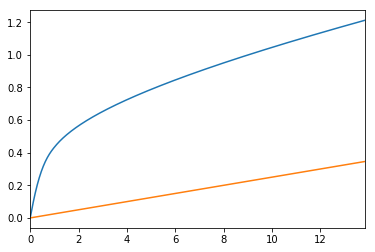

Solving the same model "the long way" took 2.102378 seconds.


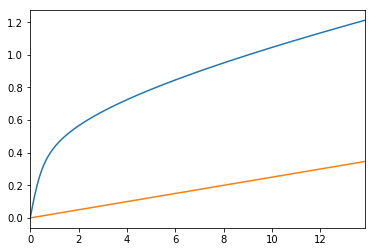

Difference between the (employed) consumption functions:


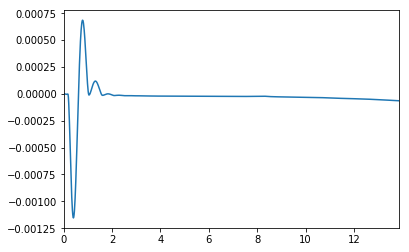

In [13]:
    ExampleType.solve()
    
    #print('Solving a tractable consumption-savings model took ' + str(t_end-t_start) + ' seconds.')
    
    # Plot the consumption function and whatnot
    m_upper = 1.5*ExampleType.mTarg
    conFunc_PF = lambda m: ExampleType.h*ExampleType.PFMPC + ExampleType.PFMPC*m
    #plotFuncs([ExampleType.solution[0].cFunc,ExampleType.mSSfunc,ExampleType.cSSfunc],0,m_upper)
    plotFuncs([ExampleType.solution[0].cFunc,ExampleType.solution[0].cFunc_U],0,m_upper)
    
    do_simulation = True # NEED TO DESCRIBE THIS
    
    # Define a dictionary to be used in case of simulation
    simulation_values = {'aLvlInitMean' : 0.0,  # Mean of log initial assets for new agents 
                         'aLvlInitStd' : 1.0,   # Stdev of log initial assets for new agents
                         'AgentCount' : 10000,  # Number of agents to simulate
                         'T_sim' : 120,         # Number of periods to simulate
                         'T_cycle' : 1}         # Number of periods in the cycle
    
    if do_simulation:
        ExampleType(**simulation_values) # Set attributes needed for simulation
        ExampleType.track_vars = ['mLvlNow']
        ExampleType.makeShockHistory()
        ExampleType.initializeSim()
        ExampleType.simulate()
        
    
    # Now solve the same model using backward induction rather than the analytic method of TBS.
    # The TBS model is equivalent to a Markov model with two states, one of them absorbing (permanent unemployment).
    MrkvArray = np.array([[1.0-base_primitives['UnempPrb'],base_primitives['UnempPrb']],[0.0,1.0]]) # Define the two state, absorbing unemployment Markov array
    init_consumer_objects = {"CRRA":base_primitives['CRRA'],
                            "Rfree":np.array(2*[base_primitives['Rfree']]), # Interest factor (same in both states)
                            "PermGroFac":[np.array(2*[base_primitives['PermGroFac']/(1.0-base_primitives['UnempPrb'])])], # Unemployment-compensated permanent growth factor
                            "BoroCnstArt":None,   # Artificial borrowing constraint
                            "PermShkStd":[0.0],   # Permanent shock standard deviation
                            "PermShkCount":1,     # Number of shocks in discrete permanent shock distribution
                            "TranShkStd":[0.0],   # Transitory shock standard deviation
                            "TranShkCount":1,     # Number of shocks in discrete permanent shock distribution
                            "T_cycle":1,          # Number of periods in cycle
                            "UnempPrb":0.0,       # Unemployment probability (not used, as the unemployment here is *permanent*, not transitory)
                            "UnempPrbRet":0.0,    # Unemployment probability when retired (irrelevant here)
                            "T_retire":0,         # Age at retirement (turned off)
                            "IncUnemp":0.0,       # Income when unemployed (irrelevant)
                            "IncUnempRet":0.0,    # Income when unemployed and retired (irrelevant)
                            "aXtraMin":0.001,     # Minimum value of assets above minimum in grid
                            "aXtraMax":ExampleType.mUpperBnd, # Maximum value of assets above minimum in grid
                            "aXtraCount":48,      # Number of points in assets grid
                            "aXtraExtra":[None],  # Additional points to include in assets grid
                            "aXtraNestFac":3,     # Degree of exponential nesting when constructing assets grid
                            "LivPrb":[np.array([1.0,1.0])], # Survival probability
                            "DiscFac":base_primitives['DiscFac'], # Intertemporal discount factor
                            'AgentCount':1,       # Number of agents in a simulation (irrelevant)
                            'tax_rate':0.0,       # Tax rate on labor income (irrelevant)
                            'vFuncBool':False,    # Whether to calculate the value function
                            'CubicBool':True,     # Whether to use cubic splines (False --> linear splines)
                            'MrkvArray':[MrkvArray] # State transition probabilities
                            }
    MarkovType = MarkovConsumerType(**init_consumer_objects)   # Make a basic consumer type
    employed_income_dist = [np.ones(1),np.ones(1),np.ones(1)]    # Income distribution when employed
    unemployed_income_dist = [np.ones(1),np.ones(1),np.zeros(1)] # Income distribution when permanently unemployed
    MarkovType.IncomeDstn = [[employed_income_dist,unemployed_income_dist]]  # set the income distribution in each state
    MarkovType.cycles = 0
    
    # Solve the "Markov TBS" model
    t_start = clock()
    MarkovType.solve()
    t_end = clock()
    MarkovType.unpackcFunc()
    
    print('Solving the same model "the long way" took ' + str(t_end-t_start) + ' seconds.')
    #plotFuncs([ExampleType.solution[0].cFunc,ExampleType.solution[0].cFunc_U],0,m_upper)
    plotFuncs(MarkovType.cFunc[0],0,m_upper)
    diffFunc = lambda m : ExampleType.solution[0].cFunc(m) - MarkovType.cFunc[0][0](m)
    print('Difference between the (employed) consumption functions:')
    plotFuncs(diffFunc,0,m_upper)